# Gas Repricing Analysis: Empirical Impact of 128x Gas Cost Increases

## Overview

This notebook analyzes divergence data from a modified Ethereum node that executes every mainnet transaction twice:
1. **Normal execution**: Standard gas costs
2. **Experimental execution**: 128x increased gas costs

The goal is to identify which transaction patterns and operations are sensitive to gas price increases, providing empirical evidence for EIP proposals that modify opcode and precompile gas costs.

## Database

- **Source**: SQLite database `divergences.db`
- **Main table**: `divergences` containing transactions that behaved differently under higher gas costs
- **Key metrics**: Gas usage, operation counts, divergence types, OOG (Out-of-Gas) events

## Research Questions

1. What percentage of transactions show divergent behavior under 128x gas costs?
2. What are the main causes of divergence?
3. Which operations/patterns are most gas-sensitive?
4. What's the impact on different contract types?
5. How severe are the divergences?


## 1. Setup and Data Loading

Import necessary libraries and configure visualization settings.

In [1]:
# Core libraries
import sqlite3
import pandas as pd
import numpy as np
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Configure matplotlib for high-quality figures
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (12, 6)

# For Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.3.4


### 1.1 Connect to Database and Explore Schema

In [2]:
# Connect to the SQLite database
DB_PATH = 'divergences.db'

conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

# Explore the database schema
cursor.execute("SELECT sql FROM sqlite_master WHERE type='table';")
schema = cursor.fetchall()

print("Database Schema:")
print("=" * 80)
for table in schema:
    print(table[0])
    print()

# Get table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in database:", [t[0] for t in tables])

Database Schema:
CREATE TABLE divergences (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                block_number INTEGER NOT NULL,
                tx_index INTEGER NOT NULL,
                tx_hash BLOB NOT NULL,
                timestamp INTEGER NOT NULL,

                -- Divergence classification (comma-separated types)
                divergence_types TEXT NOT NULL,

                -- Gas analysis
                normal_gas_used INTEGER NOT NULL,
                experimental_gas_used INTEGER NOT NULL,
                gas_efficiency_ratio REAL NOT NULL,

                -- Operation counts (normal)
                normal_sload_count INTEGER,
                normal_sstore_count INTEGER,
                normal_call_count INTEGER,
                normal_log_count INTEGER,
                normal_total_ops INTEGER,
                normal_memory_words INTEGER,
                normal_create_count INTEGER,

                -- Operation counts (experimental)
                

### 1.2 Load Divergence Data

In [3]:
# Load all divergence data
# Note: Binary fields (BLOBs) are loaded as bytes and will be converted to hex strings
query = """
SELECT 
    block_number,
    tx_index,
    tx_hash,
    divergence_types,
    normal_gas_used,
    experimental_gas_used,
    gas_efficiency_ratio,
    normal_sload_count,
    normal_sstore_count,
    normal_call_count,
    normal_log_count,
    exp_sload_count,
    exp_sstore_count,
    exp_call_count,
    exp_log_count,
    oog_occurred,
    oog_pattern,
    oog_opcode_name,
    divergence_contract,
    divergence_function_selector,
    divergence_opcode_name,
    timestamp
FROM divergences
"""

print("Loading divergence data from database...")
df = pd.read_sql_query(query, conn)
print(f"Loaded {len(df):,} divergence records")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Loading divergence data from database...
Loaded 145,880 divergence records
Memory usage: 52.06 MB


### 1.3 Data Preprocessing

Convert binary fields to hex strings and parse comma-separated divergence types.

In [4]:
# Helper function to convert bytes to hex string
def bytes_to_hex(b):
    """Convert bytes to hex string with 0x prefix, handling None values."""
    if b is None or (isinstance(b, float) and pd.isna(b)):
        return None
    if isinstance(b, bytes):
        return '0x' + b.hex()
    return b

# Convert binary fields (BLOBs) to hex strings
binary_fields = ['tx_hash', 'divergence_contract', 'divergence_function_selector']

for field in binary_fields:
    if field in df.columns:
        df[field] = df[field].apply(bytes_to_hex)
        
print("Converted binary fields to hex strings")

# Parse comma-separated divergence_types into boolean columns
# Possible types: status, gas_pattern, state_root, logs, return_data
divergence_type_options = ['status', 'gas_pattern', 'state_root', 'logs', 'return_data']

for dtype in divergence_type_options:
    df[f'has_{dtype}_divergence'] = df['divergence_types'].str.contains(dtype, na=False)
    
print("Parsed divergence_types into boolean columns")

# Convert timestamps to datetime
df['block_datetime'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')

# Create derived metrics
df['gas_difference'] = df['experimental_gas_used'] - df['normal_gas_used']
df['gas_multiplier'] = df['experimental_gas_used'] / df['normal_gas_used']

# Flag for simple transfers (likely gas_efficiency_ratio = 1/128 for 21000 gas transfers)
df['is_simple_transfer'] = (df['normal_gas_used'] <= 21000) & (df['gas_efficiency_ratio'] < 0.01)

print("Created derived metrics")
print("\nPreprocessing complete!")

Converted binary fields to hex strings
Parsed divergence_types into boolean columns
Created derived metrics

Preprocessing complete!


### 1.4 Dataset Overview

In [5]:
# Display basic dataset information
print("Dataset Shape:", df.shape)
print(f"Total divergences: {len(df):,}\n")

print("Column Data Types:")
print(df.dtypes)
print("\n" + "="*80 + "\n")

# Display first few rows
print("Sample of data (first 5 rows):")
df.head()

Dataset Shape: (145880, 31)
Total divergences: 145,880

Column Data Types:
block_number                             int64
tx_index                                 int64
tx_hash                                 object
divergence_types                        object
normal_gas_used                          int64
experimental_gas_used                    int64
gas_efficiency_ratio                   float64
normal_sload_count                       int64
normal_sstore_count                      int64
normal_call_count                        int64
normal_log_count                         int64
exp_sload_count                          int64
exp_sstore_count                         int64
exp_call_count                           int64
exp_log_count                            int64
oog_occurred                             int64
oog_pattern                             object
oog_opcode_name                         object
divergence_contract                     object
divergence_function_selector    

,block_number,tx_index,tx_hash,divergence_types,normal_gas_used,experimental_gas_used,gas_efficiency_ratio,normal_sload_count,normal_sstore_count,normal_call_count,...,timestamp,has_status_divergence,has_gas_pattern_divergence,has_state_root_divergence,has_logs_divergence,has_return_data_divergence,block_datetime,gas_difference,gas_multiplier,is_simple_transfer
0,2571372,9,0x0874e15fd07f92bf1143f9abd289c7c0737330782457...,gas_pattern,21000,21000,0.007812,0,0,0,...,1478358832,False,True,False,False,False,2016-11-05 15:13:52,0,1.000000,True
1,2636502,9,0xdf14e90b3a08305b19b1a92ed8614f91673def3689b7...,"status,gas_pattern,state_root",443439,489786,0.008629,3,3,0,...,1479285757,True,True,True,False,False,2016-11-16 08:42:37,46347,1.104517,False
2,2655727,19,0x2651977c7415087de9c16183a832ae277bd43fbc426d...,gas_pattern,23256,23256,0.007812,0,0,0,...,1479559069,False,True,False,False,False,2016-11-19 12:37:49,0,1.000000,False
3,2672776,32,0x0b3203aa5683f4cfe98c5437351209f23b8ac09e6218...,gas_pattern,21000,21000,0.007812,0,0,0,...,1479799688,False,True,False,False,False,2016-11-22 07:28:08,0,1.000000,True
4,2687232,6,0xafe9cb1e4ab5074e4f292d4c9cd3acb421bd7861e4fa...,gas_pattern,668681,729768,0.008526,0,0,0,...,1480011737,False,True,False,False,False,2016-11-24 18:22:17,61087,1.091354,False


In [6]:
# Check for missing values
print("Missing Values by Column:")
print(df.isnull().sum()[df.isnull().sum() > 0])
print(f"\nPercentage of rows with any missing value: {(df.isnull().any(axis=1).sum() / len(df) * 100):.2f}%")

Missing Values by Column:
oog_pattern                     144659
oog_opcode_name                 144659
divergence_contract             144659
divergence_function_selector    145880
divergence_opcode_name          144659
dtype: int64

Percentage of rows with any missing value: 100.00%


## 2. Data Overview and Summary Statistics

Comprehensive statistics about the divergence dataset, including block coverage, divergence types, and gas metrics.

### 2.1 Basic Statistics

In [7]:
# Core statistics
print("=" * 80)
print("DATASET SUMMARY")
print("=" * 80)
print(f"\nTotal Divergences: {len(df):,}")
print(f"\nBlock Range: {df['block_number'].min():,} to {df['block_number'].max():,}")
print(f"Total Blocks Covered: {df['block_number'].nunique():,}")

# Date range
if df['block_datetime'].notna().any():
    min_date = df['block_datetime'].min()
    max_date = df['block_datetime'].max()
    print(f"\nDate Range: {min_date} to {max_date}")
    print(f"Time Span: {(max_date - min_date).days} days")

# Divergence type breakdown
print("\n" + "=" * 80)
print("DIVERGENCE TYPE BREAKDOWN")
print("=" * 80)
for dtype in ['status', 'gas_pattern', 'state_root', 'logs', 'return_data']:
    count = df[f'has_{dtype}_divergence'].sum()
    pct = (count / len(df)) * 100
    print(f"{dtype:20s}: {count:6,} ({pct:5.2f}%)")

# OOG statistics
print("\n" + "=" * 80)
print("OUT-OF-GAS (OOG) STATISTICS")
print("=" * 80)
oog_count = df['oog_occurred'].sum()
oog_pct = (oog_count / len(df)) * 100
print(f"OOG Occurrences: {oog_count:,} ({oog_pct:.2f}%)")

if oog_count > 0:
    print("\nOOG Pattern Distribution:")
    oog_patterns = df[df['oog_occurred'] == 1]['oog_pattern'].value_counts()
    for pattern, count in oog_patterns.items():
        pct = (count / oog_count) * 100
        print(f"  {pattern:20s}: {count:6,} ({pct:5.2f}%)")

# Simple transfers
simple_count = df['is_simple_transfer'].sum()
simple_pct = (simple_count / len(df)) * 100
print(f"\nSimple Transfers (≤21000 gas): {simple_count:,} ({simple_pct:.2f}%)")

DATASET SUMMARY

Total Divergences: 145,880

Block Range: 2,571,372 to 12,964,855
Total Blocks Covered: 14,149

Date Range: 2016-11-05 15:13:52 to 2021-08-05 12:04:03
Time Span: 1733 days

DIVERGENCE TYPE BREAKDOWN
status              :  1,017 ( 0.70%)
gas_pattern         : 145,880 (100.00%)
state_root          :  1,322 ( 0.91%)
logs                :      0 ( 0.00%)
return_data         :      0 ( 0.00%)

OUT-OF-GAS (OOG) STATISTICS
OOG Occurrences: 1,221 (0.84%)

OOG Pattern Distribution:
  unknown             :  1,221 (100.00%)

Simple Transfers (≤21000 gas): 17,982 (12.33%)


### 2.2 Gas Metrics Summary

In [8]:
# Gas efficiency ratio statistics
print("=" * 80)
print("GAS EFFICIENCY RATIO STATISTICS")
print("=" * 80)
print("\nGas Efficiency Ratio = (Experimental Gas - Normal Gas) / (Normal Gas * 127)")
print("Expected value for same execution path: ~1.0")
print("Value significantly ≠ 1.0 indicates different execution path\n")

print(df['gas_efficiency_ratio'].describe())

# Count transactions by gas efficiency patterns
print("\n" + "-" * 80)
print("Gas Efficiency Ratio Distribution:")
print("-" * 80)

# Define meaningful ranges
same_path = ((df['gas_efficiency_ratio'] >= 0.95) & (df['gas_efficiency_ratio'] <= 1.05)).sum()
minor_diff = ((df['gas_efficiency_ratio'] >= 0.85) & (df['gas_efficiency_ratio'] < 0.95) | 
              (df['gas_efficiency_ratio'] > 1.05) & (df['gas_efficiency_ratio'] <= 1.15)).sum()
major_diff = ((df['gas_efficiency_ratio'] < 0.85) | (df['gas_efficiency_ratio'] > 1.15)).sum()

total = len(df)
print(f"Same path (0.95-1.05):     {same_path:6,} ({same_path/total*100:5.2f}%)")
print(f"Minor difference (±10%):    {minor_diff:6,} ({minor_diff/total*100:5.2f}%)")
print(f"Major difference (>±15%):   {major_diff:6,} ({major_diff/total*100:5.2f}%)")

# Normal gas usage statistics
print("\n" + "=" * 80)
print("GAS USAGE STATISTICS")
print("=" * 80)
print("\nNormal Execution Gas Used:")
print(df['normal_gas_used'].describe())

print("\nExperimental Execution Gas Used:")
print(df['experimental_gas_used'].describe())

GAS EFFICIENCY RATIO STATISTICS

Gas Efficiency Ratio = (Experimental Gas - Normal Gas) / (Normal Gas * 127)
Expected value for same execution path: ~1.0
Value significantly ≠ 1.0 indicates different execution path

count    145880.000000
mean          0.007837
std           0.000261
min           0.007812
25%           0.007812
50%           0.007812
75%           0.007812
max           0.072567
Name: gas_efficiency_ratio, dtype: float64

--------------------------------------------------------------------------------
Gas Efficiency Ratio Distribution:
--------------------------------------------------------------------------------
Same path (0.95-1.05):          0 ( 0.00%)
Minor difference (±10%):         0 ( 0.00%)
Major difference (>±15%):   145,880 (100.00%)

GAS USAGE STATISTICS

Normal Execution Gas Used:
count    1.458800e+05
mean     2.826245e+04
std      3.299995e+04
min      2.100000e+04
25%      2.293600e+04
50%      2.325600e+04
75%      2.325600e+04
max      2.704949e+06


### 2.3 Visualizations

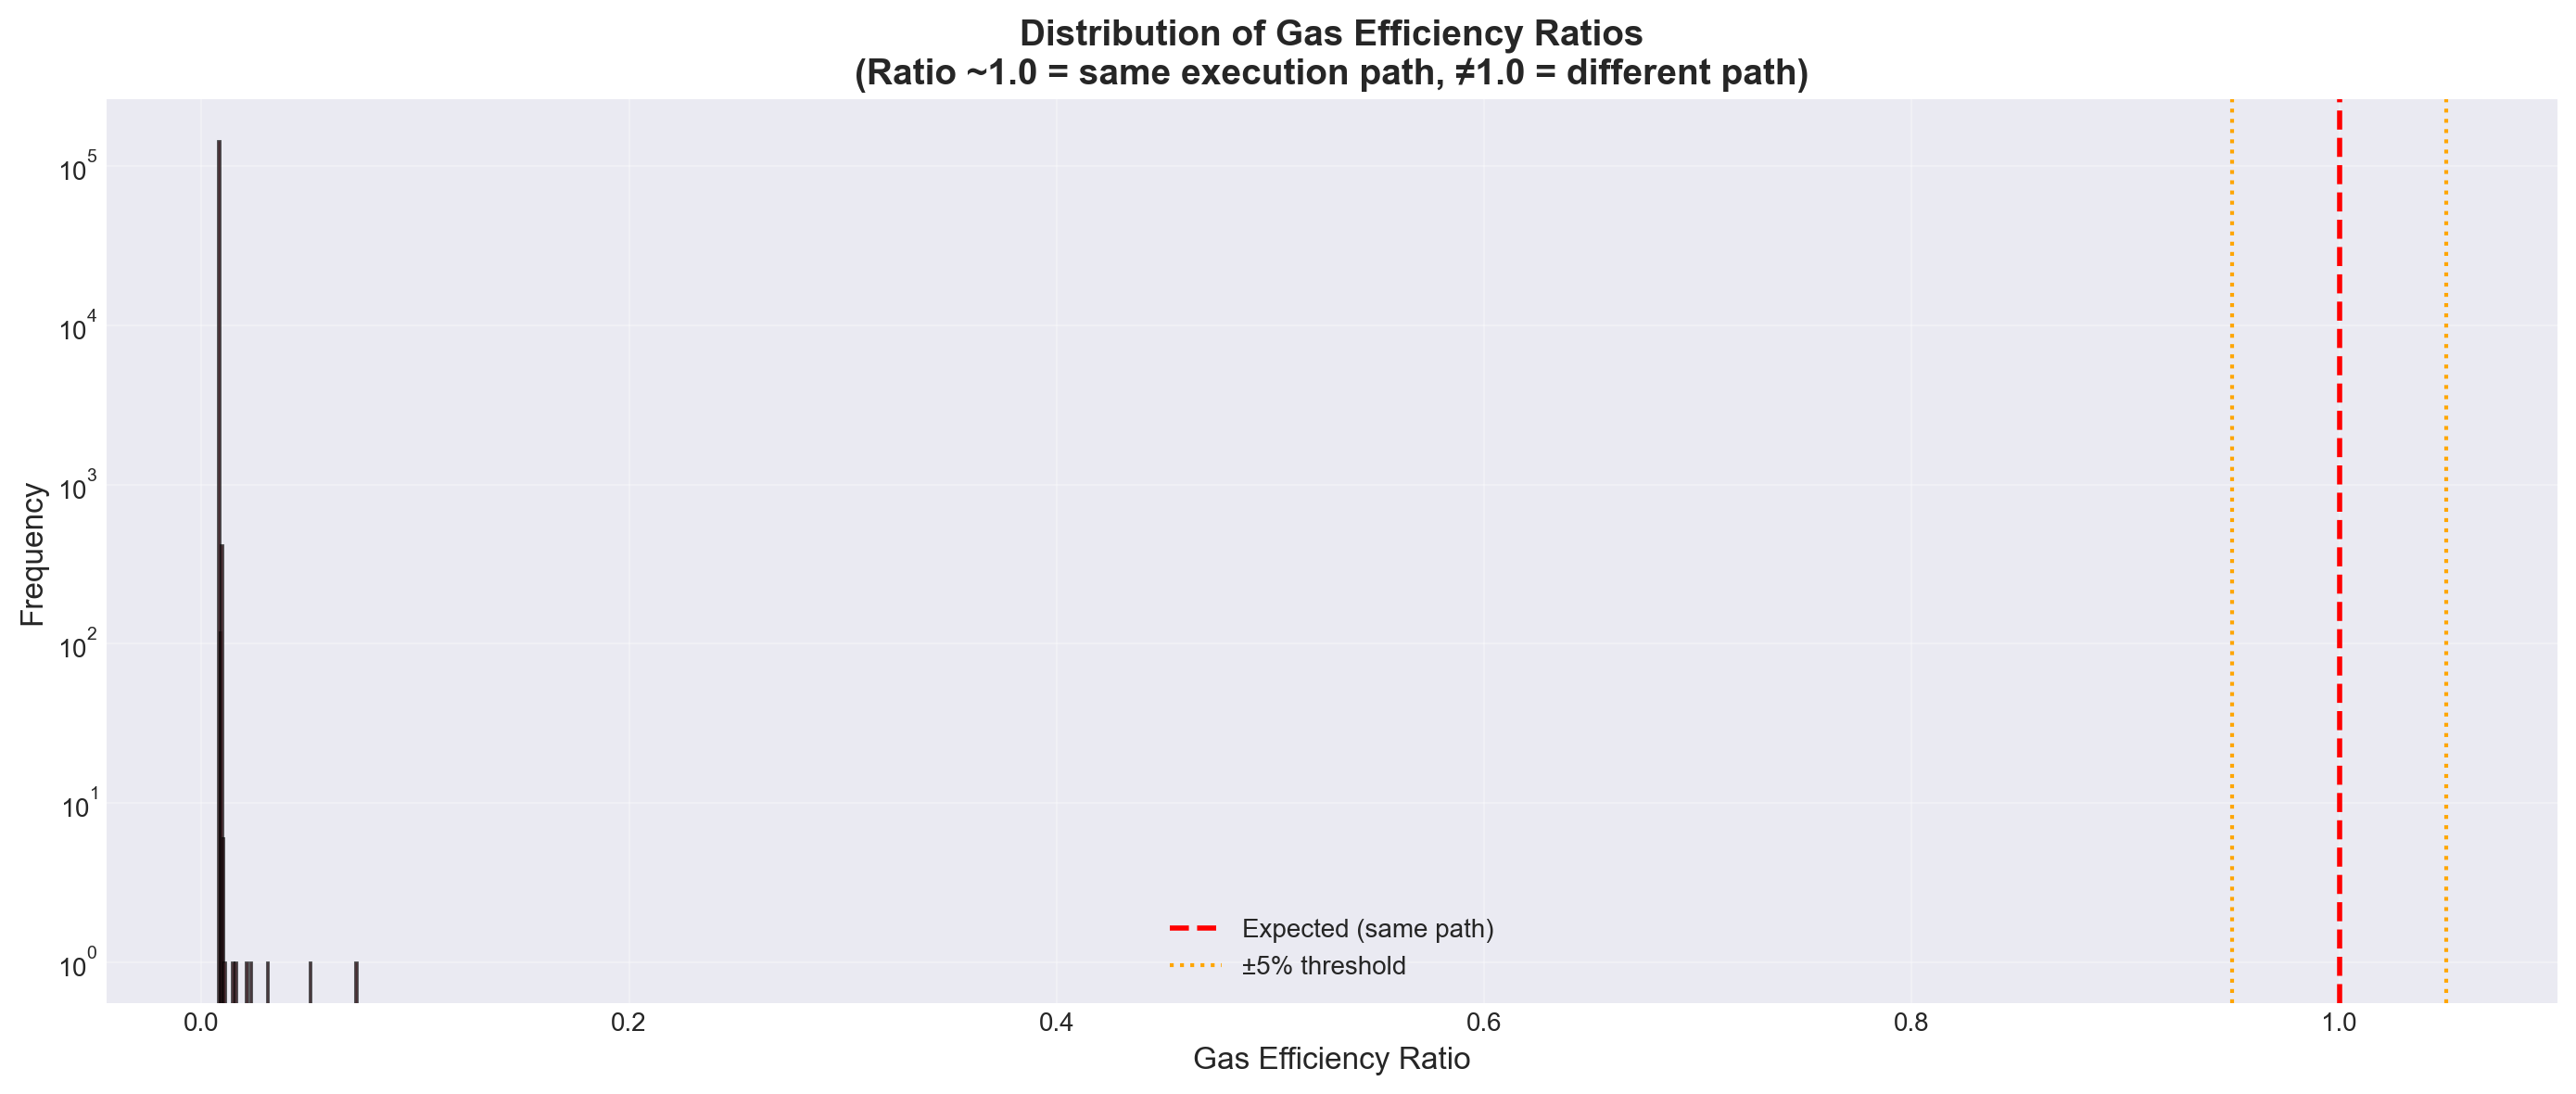

Median gas efficiency ratio: 0.0078
Mean gas efficiency ratio: 0.0078
Std dev: 0.0003


In [18]:
# Gas Efficiency Ratio Distribution
fig, ax = plt.subplots(figsize=(14, 6))

# Plot histogram
ax.hist(df['gas_efficiency_ratio'], bins=100, edgecolor='black', alpha=0.7)

# Mark important thresholds
ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Expected (same path)')
ax.axvline(x=0.95, color='orange', linestyle=':', linewidth=1.5, label='±5% threshold')
ax.axvline(x=1.05, color='orange', linestyle=':', linewidth=1.5)

ax.set_yscale('log')

ax.set_xlabel('Gas Efficiency Ratio', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Gas Efficiency Ratios\n(Ratio ~1.0 = same execution path, ≠1.0 = different path)', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics summary
print(f"Median gas efficiency ratio: {df['gas_efficiency_ratio'].median():.4f}")
print(f"Mean gas efficiency ratio: {df['gas_efficiency_ratio'].mean():.4f}")
print(f"Std dev: {df['gas_efficiency_ratio'].std():.4f}")

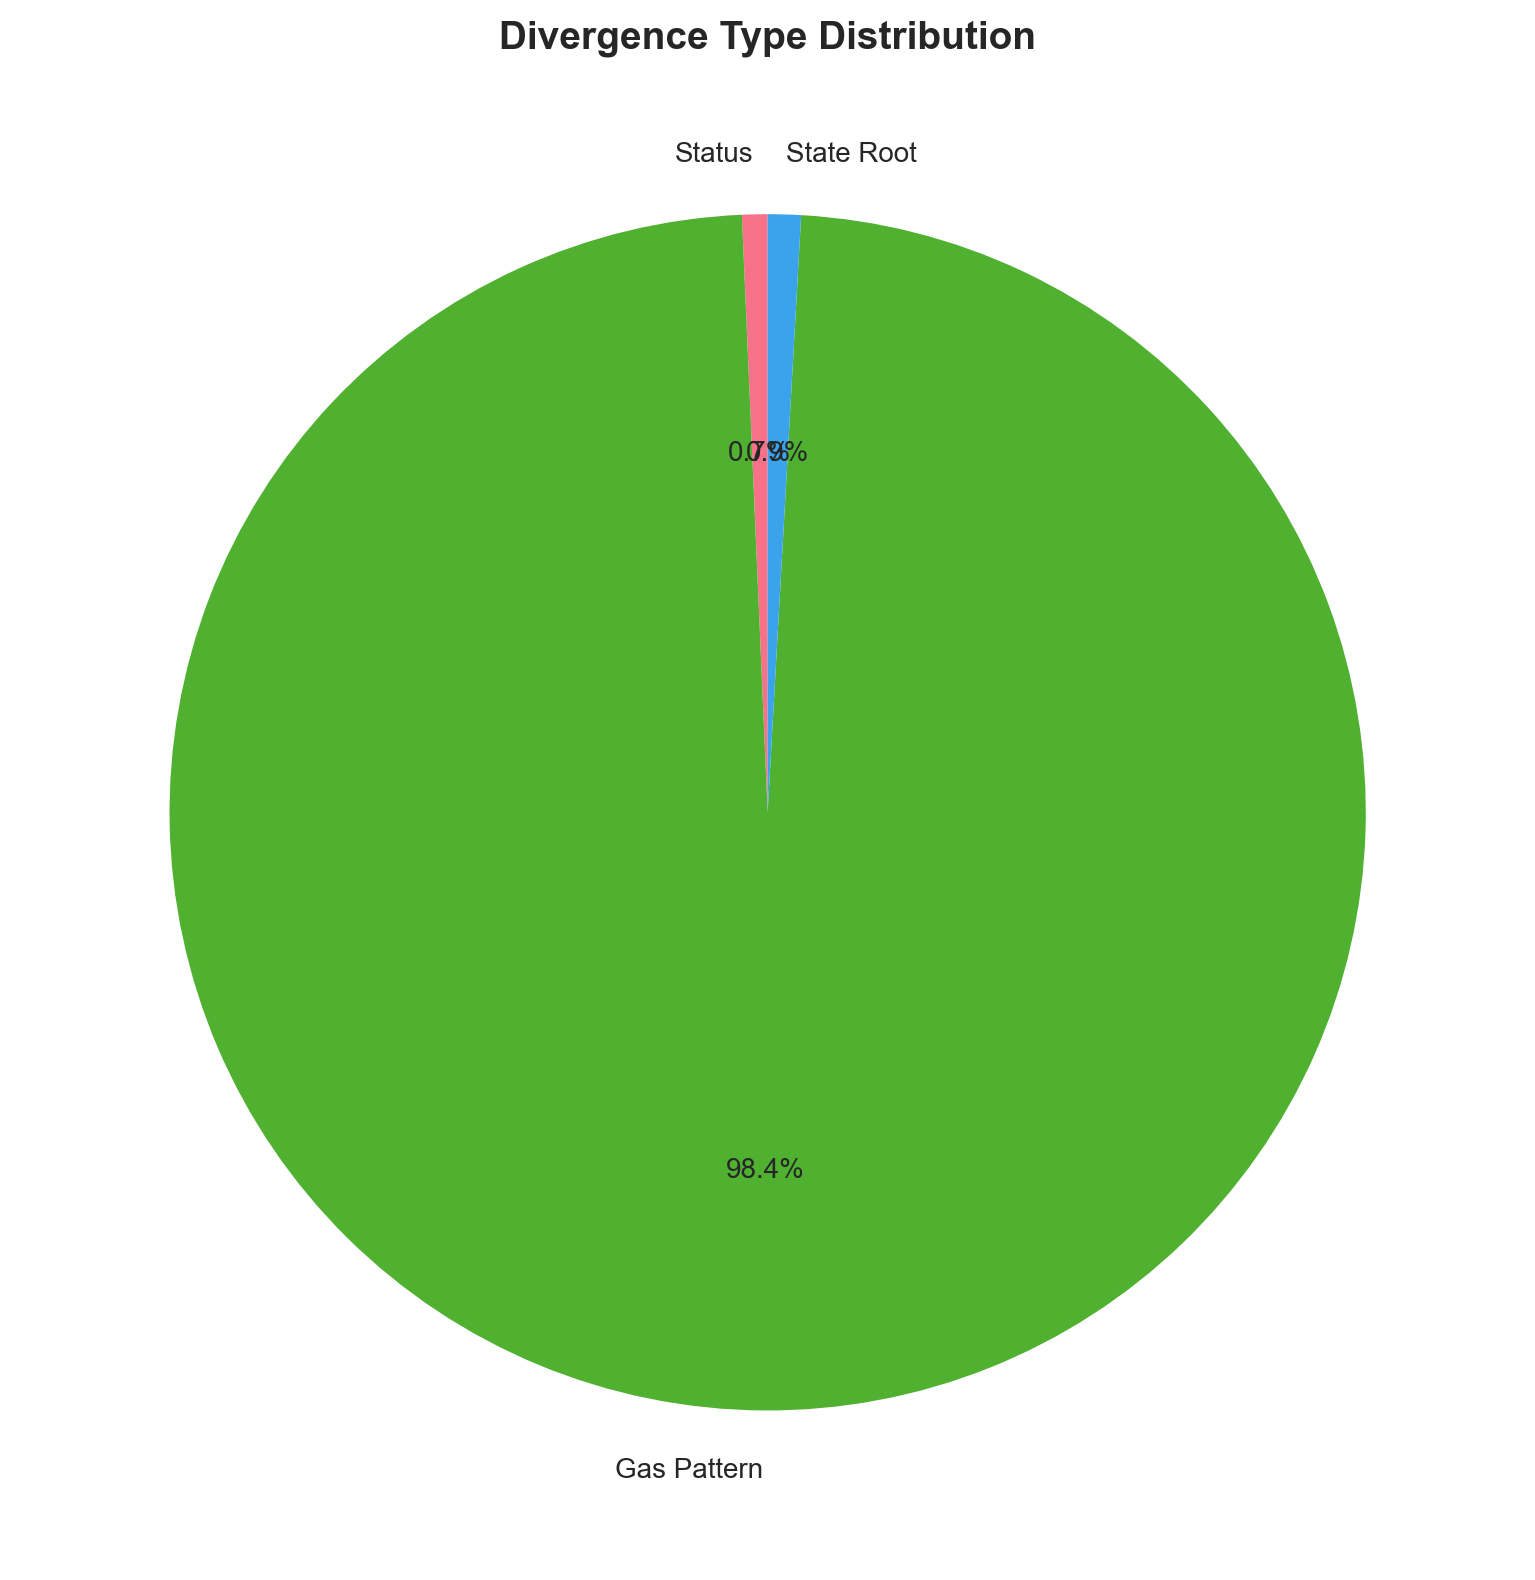

Note: A single transaction can have multiple divergence types


In [10]:
# Divergence Type Distribution (Pie Chart)
fig, ax = plt.subplots(figsize=(10, 8))

divergence_counts = []
labels = []
for dtype in ['status', 'gas_pattern', 'state_root', 'logs', 'return_data']:
    count = df[f'has_{dtype}_divergence'].sum()
    if count > 0:
        divergence_counts.append(count)
        labels.append(dtype.replace('_', ' ').title())

colors = sns.color_palette("husl", len(labels))
ax.pie(divergence_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax.set_title('Divergence Type Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("Note: A single transaction can have multiple divergence types")

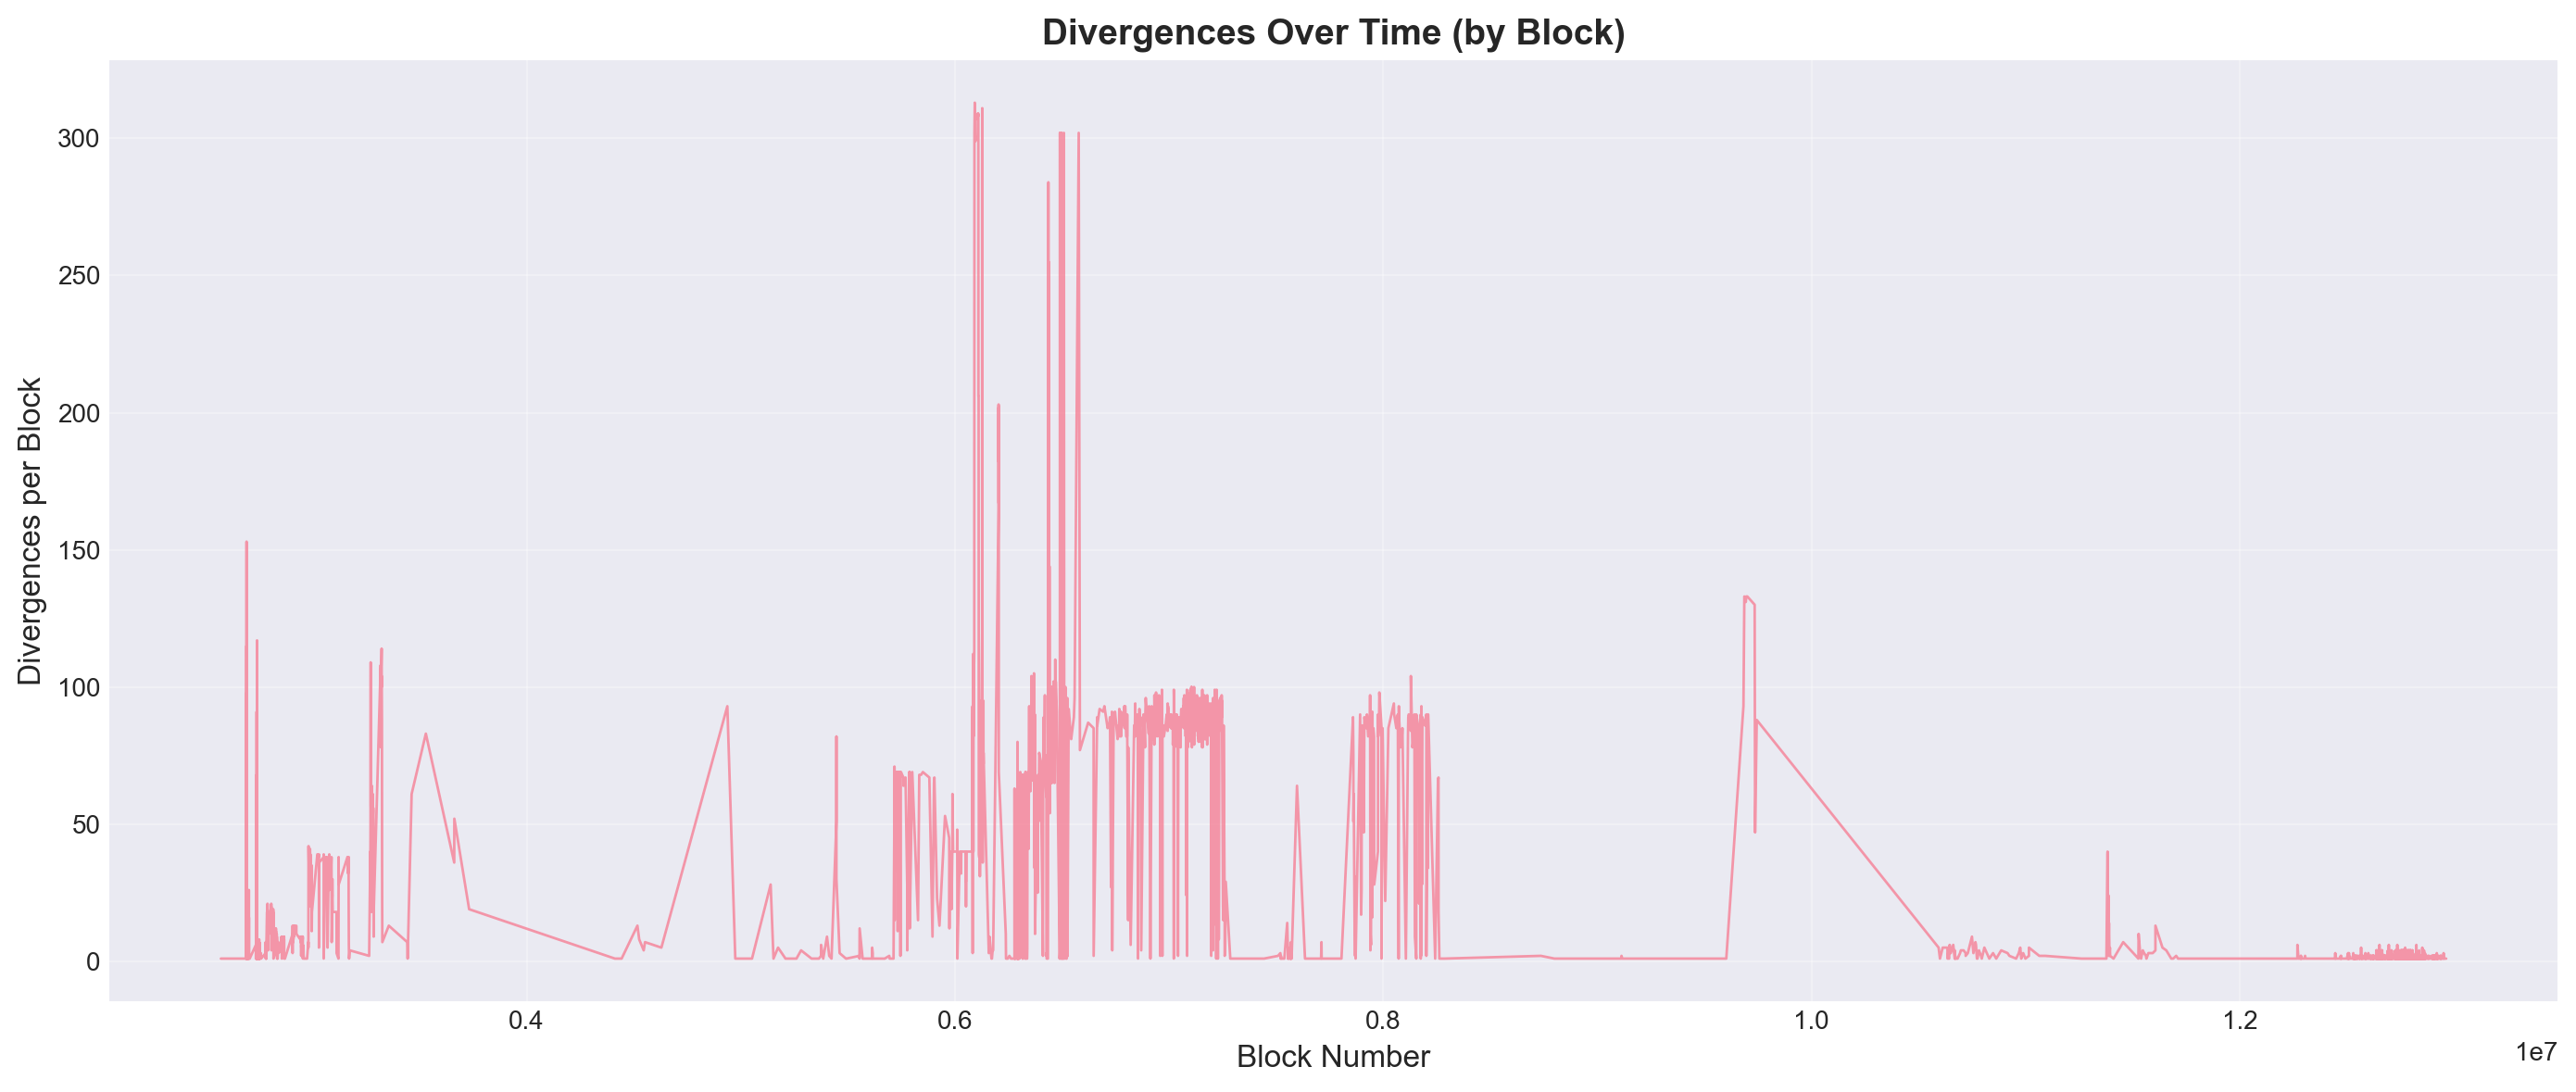

Average divergences per block: 10.31
Max divergences in a single block: 313


In [11]:
# Timeline: Divergences over time
fig, ax = plt.subplots(figsize=(14, 6))

# Group by block and count divergences
divergences_per_block = df.groupby('block_number').size()

ax.plot(divergences_per_block.index, divergences_per_block.values, linewidth=1, alpha=0.7)
ax.set_xlabel('Block Number', fontsize=12)
ax.set_ylabel('Divergences per Block', fontsize=12)
ax.set_title('Divergences Over Time (by Block)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average divergences per block: {divergences_per_block.mean():.2f}")
print(f"Max divergences in a single block: {divergences_per_block.max()}")

## 3. Gas Analysis

Deep dive into gas usage patterns and efficiency ratios to understand execution path changes.

### 3.1 Gas Usage vs Efficiency Ratio

Analyzing the relationship between transaction gas usage and how it responds to price increases.

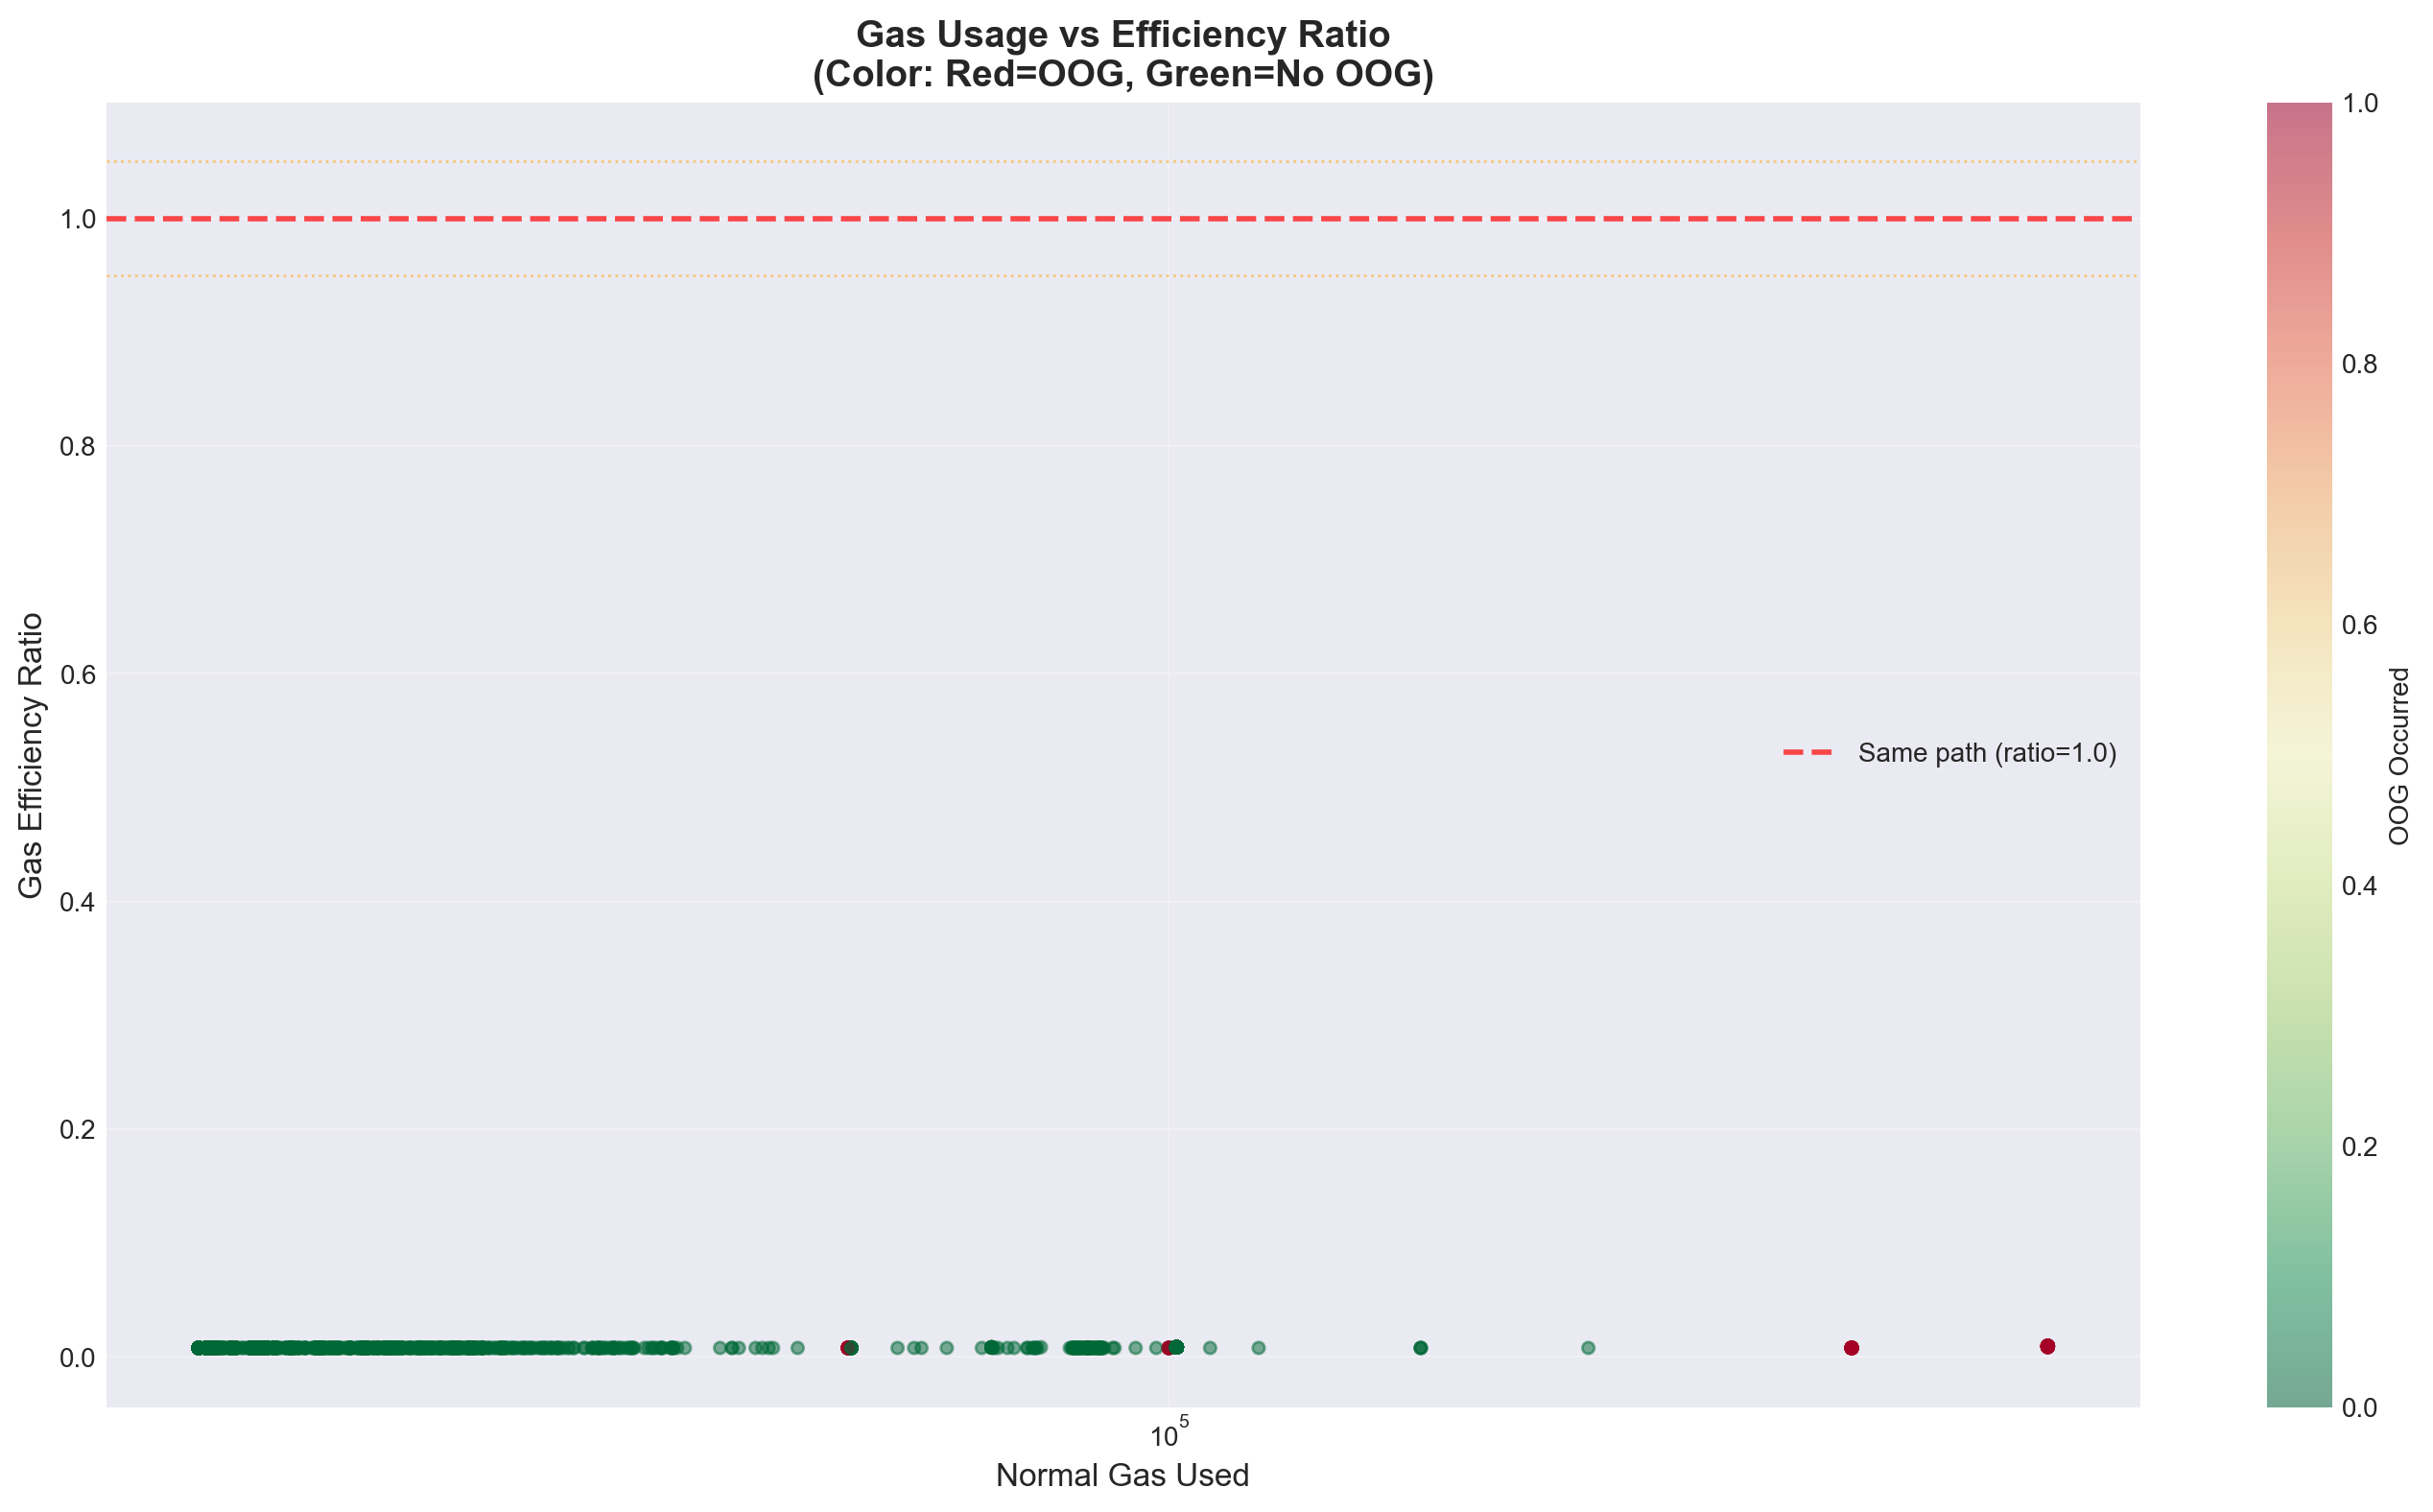

Correlation between normal gas used and efficiency ratio: 0.4256


In [12]:
# Scatter plot: Normal gas used vs gas efficiency ratio
fig, ax = plt.subplots(figsize=(14, 8))

# Sample if dataset is very large (for visualization performance)
plot_df = df.sample(min(10000, len(df))) if len(df) > 10000 else df

scatter = ax.scatter(plot_df['normal_gas_used'], 
                     plot_df['gas_efficiency_ratio'],
                     c=plot_df['oog_occurred'], 
                     cmap='RdYlGn_r',
                     alpha=0.5,
                     s=20)

# Add reference line at ratio = 1.0
ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Same path (ratio=1.0)')
ax.axhline(y=0.95, color='orange', linestyle=':', linewidth=1, alpha=0.5)
ax.axhline(y=1.05, color='orange', linestyle=':', linewidth=1, alpha=0.5)

ax.set_xlabel('Normal Gas Used', fontsize=12)
ax.set_ylabel('Gas Efficiency Ratio', fontsize=12)
ax.set_title('Gas Usage vs Efficiency Ratio\n(Color: Red=OOG, Green=No OOG)', 
             fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('OOG Occurred', fontsize=10)

plt.tight_layout()
plt.show()

# Correlation analysis
correlation = df['normal_gas_used'].corr(df['gas_efficiency_ratio'])
print(f"Correlation between normal gas used and efficiency ratio: {correlation:.4f}")

### 3.2 Gas Efficiency by Divergence Type

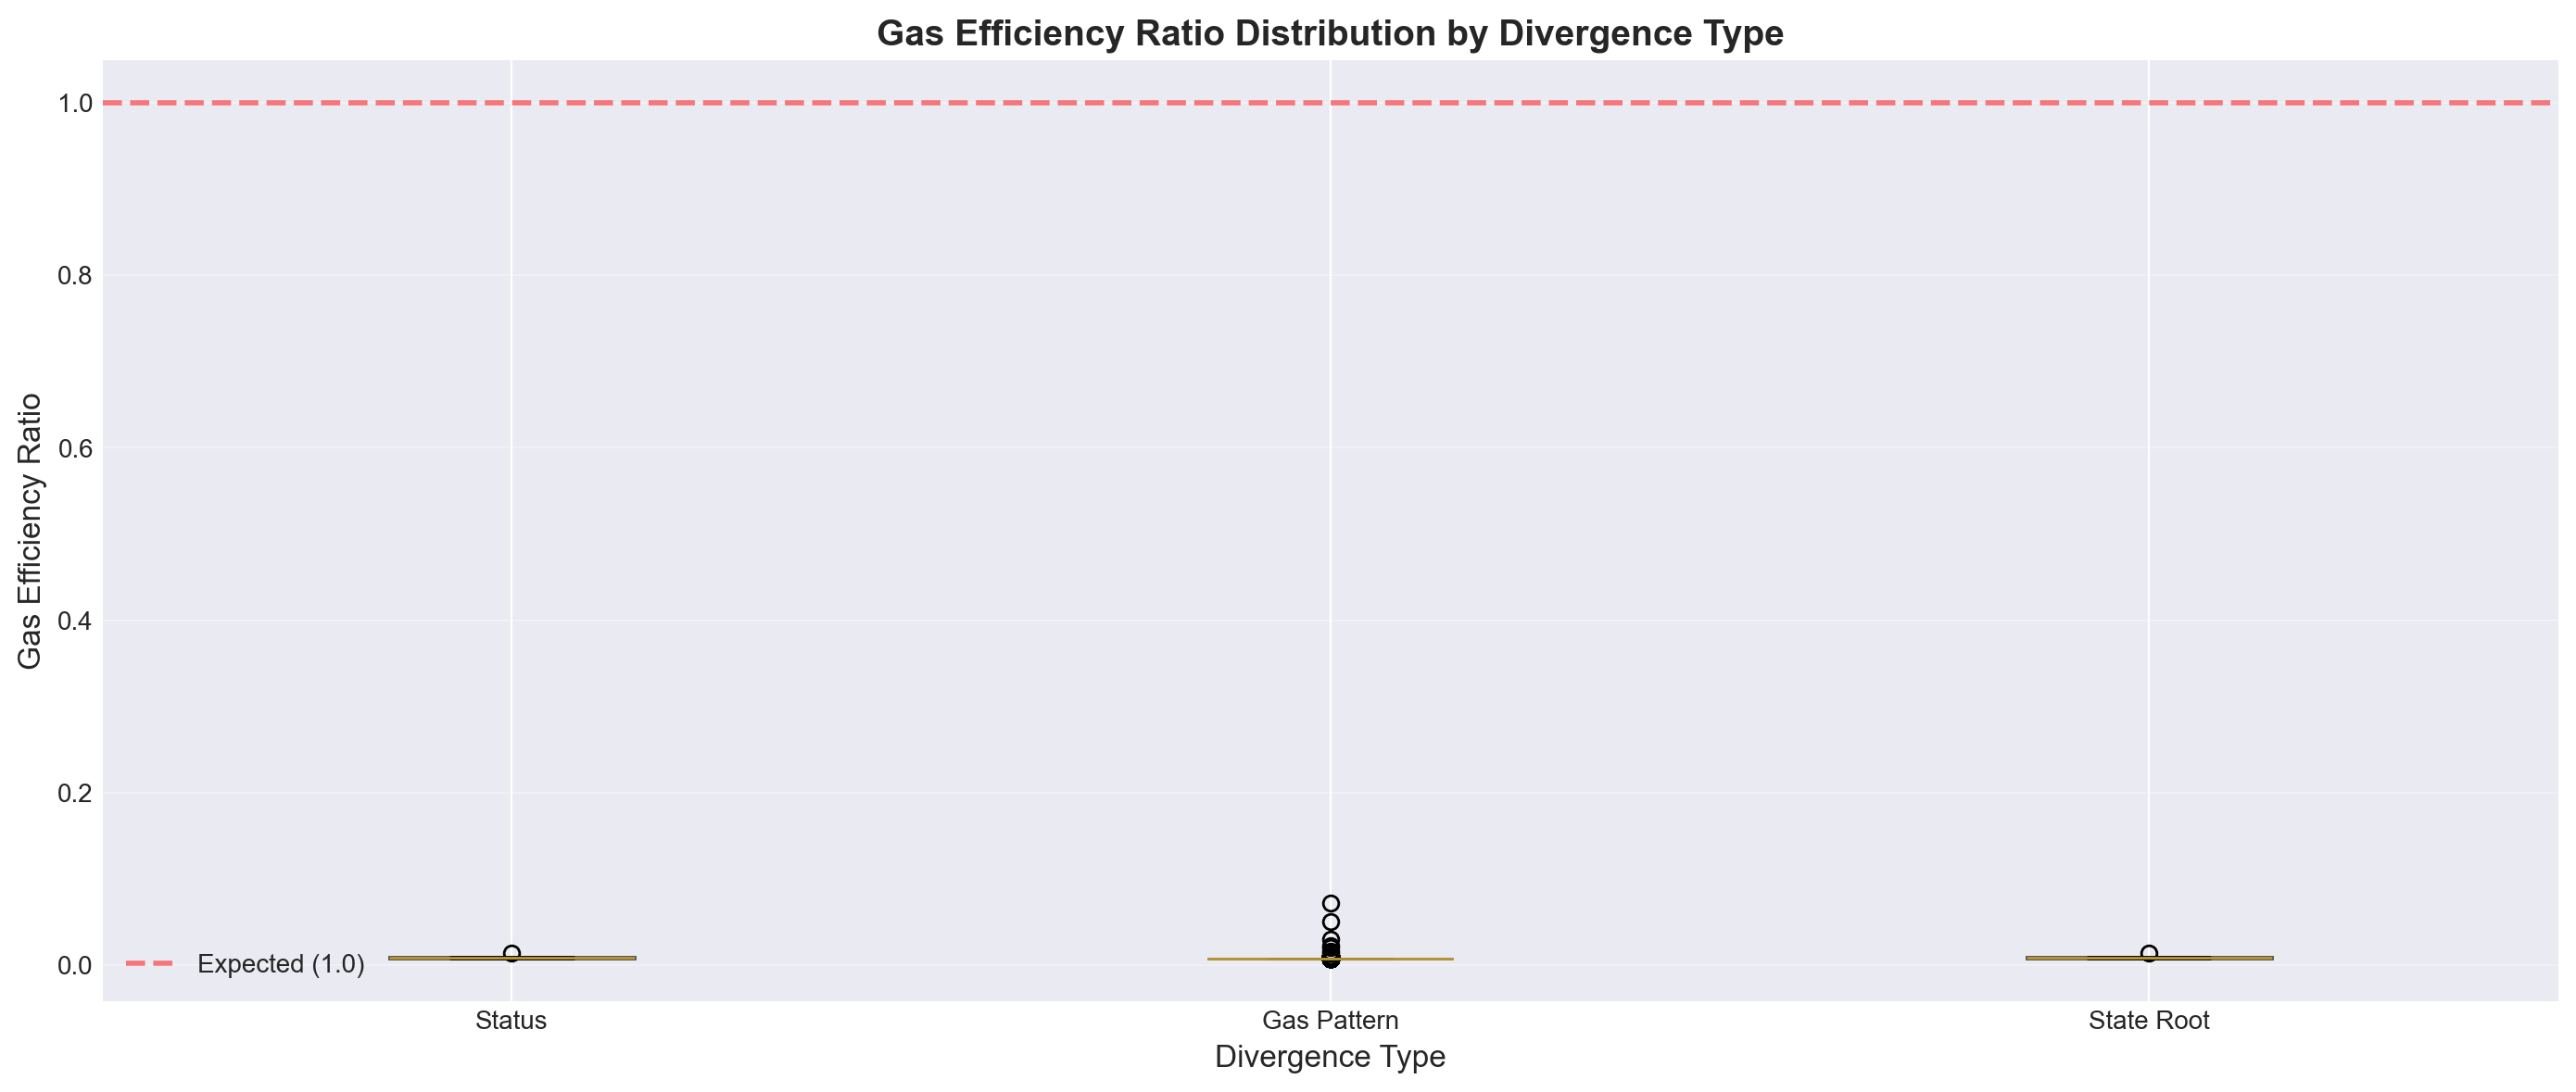

Gas Efficiency Ratio Statistics by Divergence Type:

STATUS:
  Mean: 0.0087
  Median: 0.0087
  Std Dev: 0.0007

GAS_PATTERN:
  Mean: 0.0078
  Median: 0.0078
  Std Dev: 0.0003

STATE_ROOT:
  Mean: 0.0085
  Median: 0.0083
  Std Dev: 0.0007


In [13]:
# Box plots: Gas efficiency ratio by divergence type
fig, ax = plt.subplots(figsize=(14, 6))

# Prepare data for box plot
box_data = []
labels = []
for dtype in ['status', 'gas_pattern', 'state_root', 'logs', 'return_data']:
    if df[f'has_{dtype}_divergence'].any():
        ratios = df[df[f'has_{dtype}_divergence']]['gas_efficiency_ratio']
        box_data.append(ratios)
        labels.append(dtype.replace('_', ' ').title())

bp = ax.boxplot(box_data, labels=labels, patch_artist=True)

# Color the boxes
colors = sns.color_palette("husl", len(box_data))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Expected (1.0)')
ax.set_ylabel('Gas Efficiency Ratio', fontsize=12)
ax.set_xlabel('Divergence Type', fontsize=12)
ax.set_title('Gas Efficiency Ratio Distribution by Divergence Type', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary statistics by type
print("Gas Efficiency Ratio Statistics by Divergence Type:")
print("=" * 80)
for dtype in ['status', 'gas_pattern', 'state_root', 'logs', 'return_data']:
    if df[f'has_{dtype}_divergence'].any():
        ratios = df[df[f'has_{dtype}_divergence']]['gas_efficiency_ratio']
        print(f"\n{dtype.upper()}:")
        print(f"  Mean: {ratios.mean():.4f}")
        print(f"  Median: {ratios.median():.4f}")
        print(f"  Std Dev: {ratios.std():.4f}")

### 3.3 Cumulative Distribution Function (CDF)

Shows what percentage of divergences have an efficiency ratio below a given threshold.

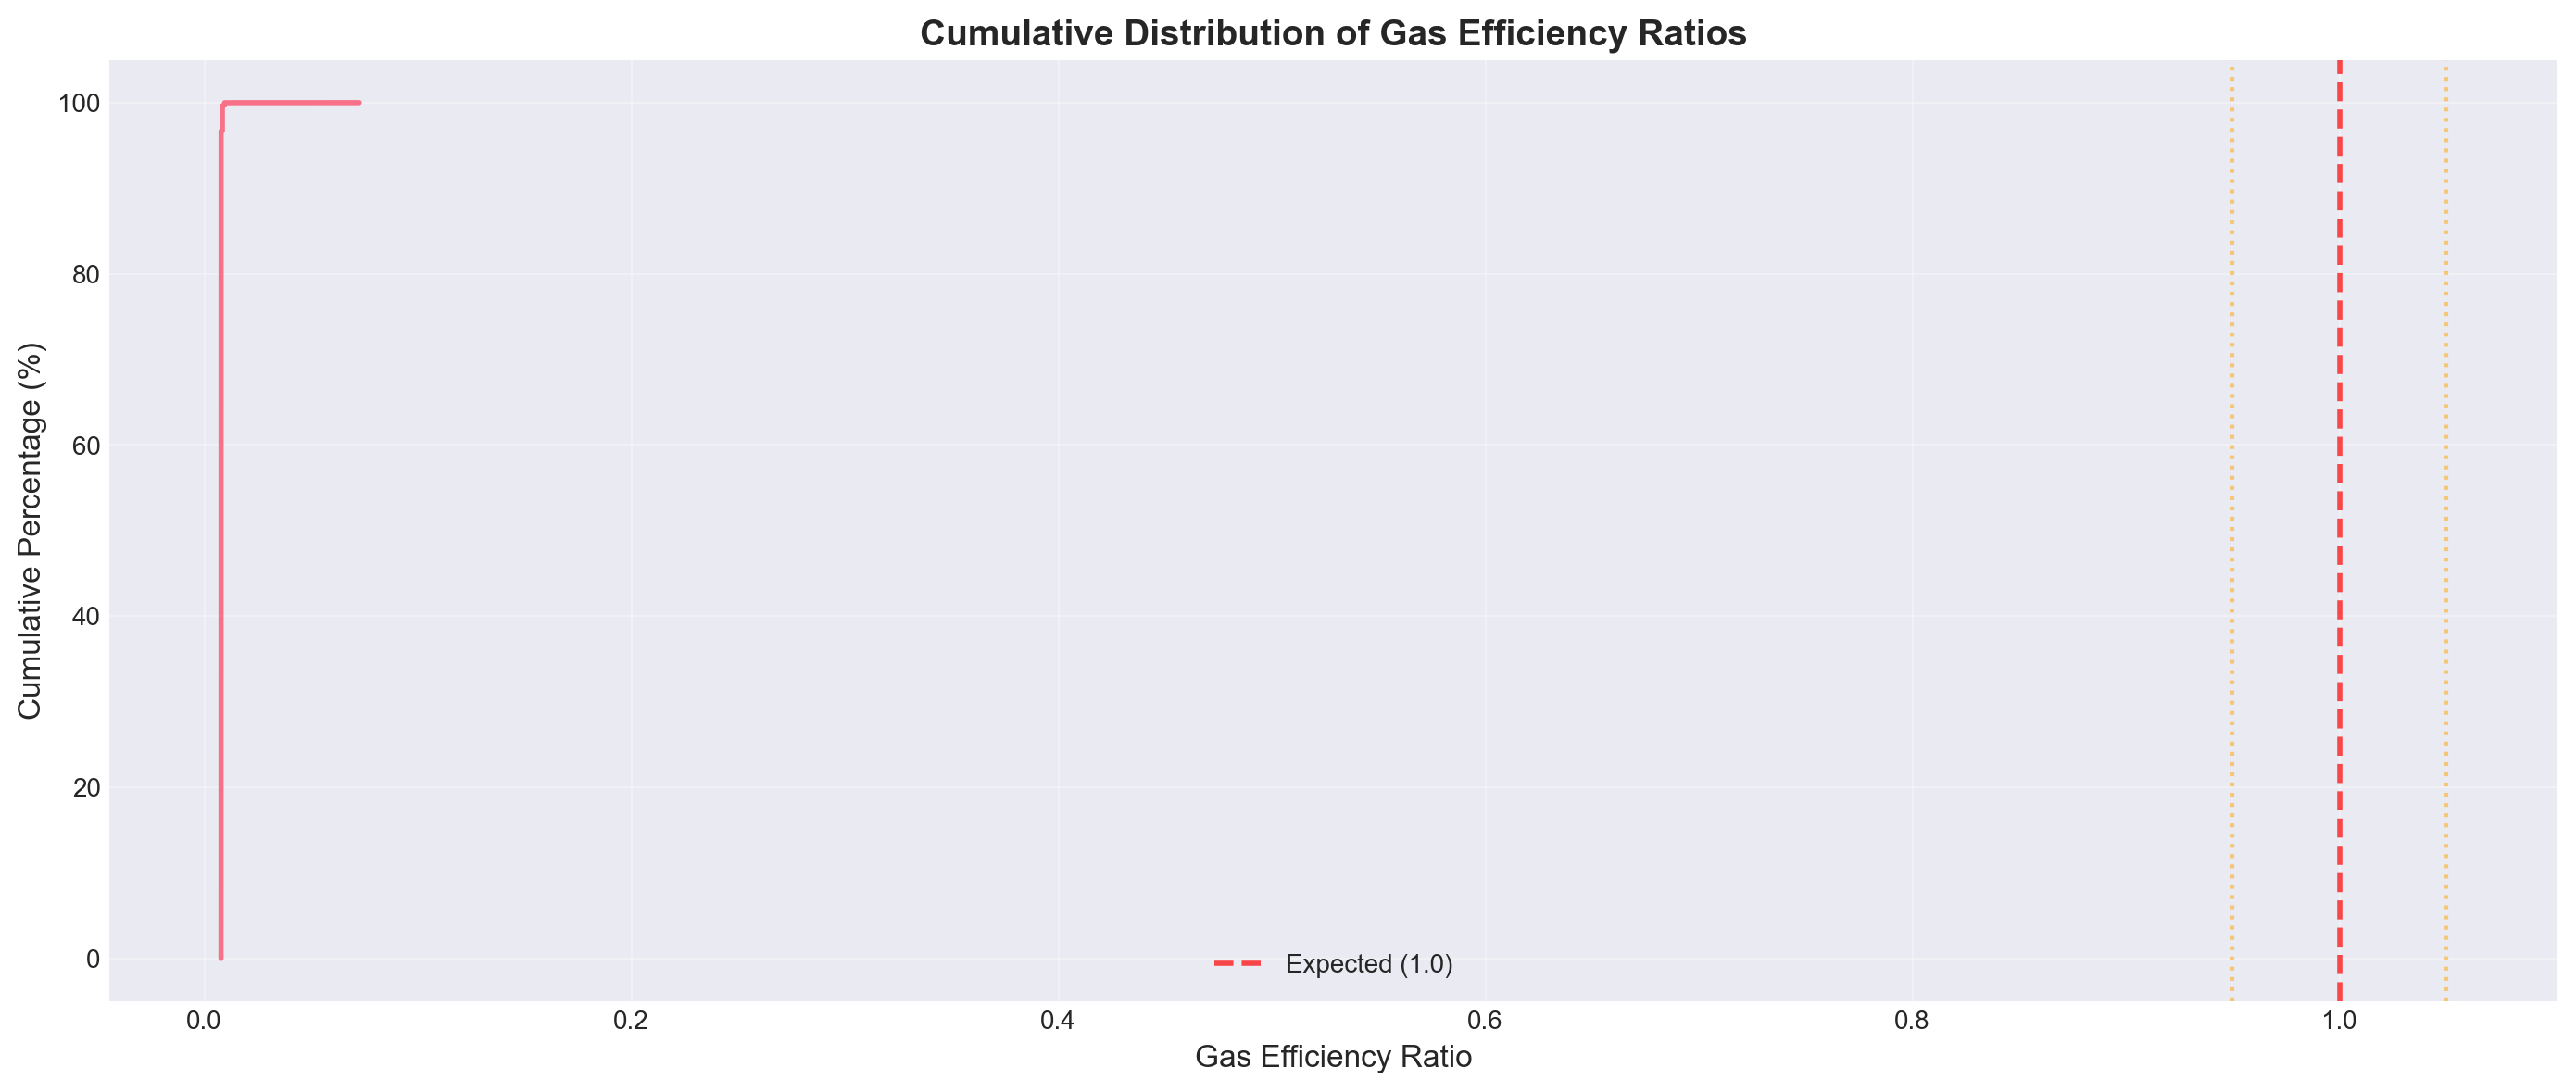

Gas Efficiency Ratio Percentiles:
  10th percentile: 0.0078
  25th percentile: 0.0078
  50th percentile: 0.0078
  75th percentile: 0.0078
  90th percentile: 0.0078
  95th percentile: 0.0078
  99th percentile: 0.0084

0.00% of divergences have efficiency ratio within ±5% of 1.0


In [14]:
# CDF of gas efficiency ratios
fig, ax = plt.subplots(figsize=(14, 6))

# Sort values and calculate cumulative percentages
sorted_ratios = np.sort(df['gas_efficiency_ratio'])
cumulative = np.arange(1, len(sorted_ratios) + 1) / len(sorted_ratios) * 100

ax.plot(sorted_ratios, cumulative, linewidth=2)
ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Expected (1.0)')
ax.axvline(x=0.95, color='orange', linestyle=':', linewidth=1.5, alpha=0.5)
ax.axvline(x=1.05, color='orange', linestyle=':', linewidth=1.5, alpha=0.5)

ax.set_xlabel('Gas Efficiency Ratio', fontsize=12)
ax.set_ylabel('Cumulative Percentage (%)', fontsize=12)
ax.set_title('Cumulative Distribution of Gas Efficiency Ratios', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
print("Gas Efficiency Ratio Percentiles:")
for p in percentiles:
    value = np.percentile(df['gas_efficiency_ratio'], p)
    print(f"  {p}th percentile: {value:.4f}")
    
# Percentage within tolerance bands
within_5pct = ((df['gas_efficiency_ratio'] >= 0.95) & (df['gas_efficiency_ratio'] <= 1.05)).sum()
print(f"\n{within_5pct/len(df)*100:.2f}% of divergences have efficiency ratio within ±5% of 1.0")

## 4. Out-of-Gas (OOG) Analysis

Deep dive into transactions that ran out of gas under 128x gas costs, representing complete execution failures.

### 4.1 OOG Pattern Breakdown

Total OOG transactions: 1,221 (0.84% of all divergences)

OOG PATTERN DISTRIBUTION
oog_pattern
unknown    1221
Name: count, dtype: int64



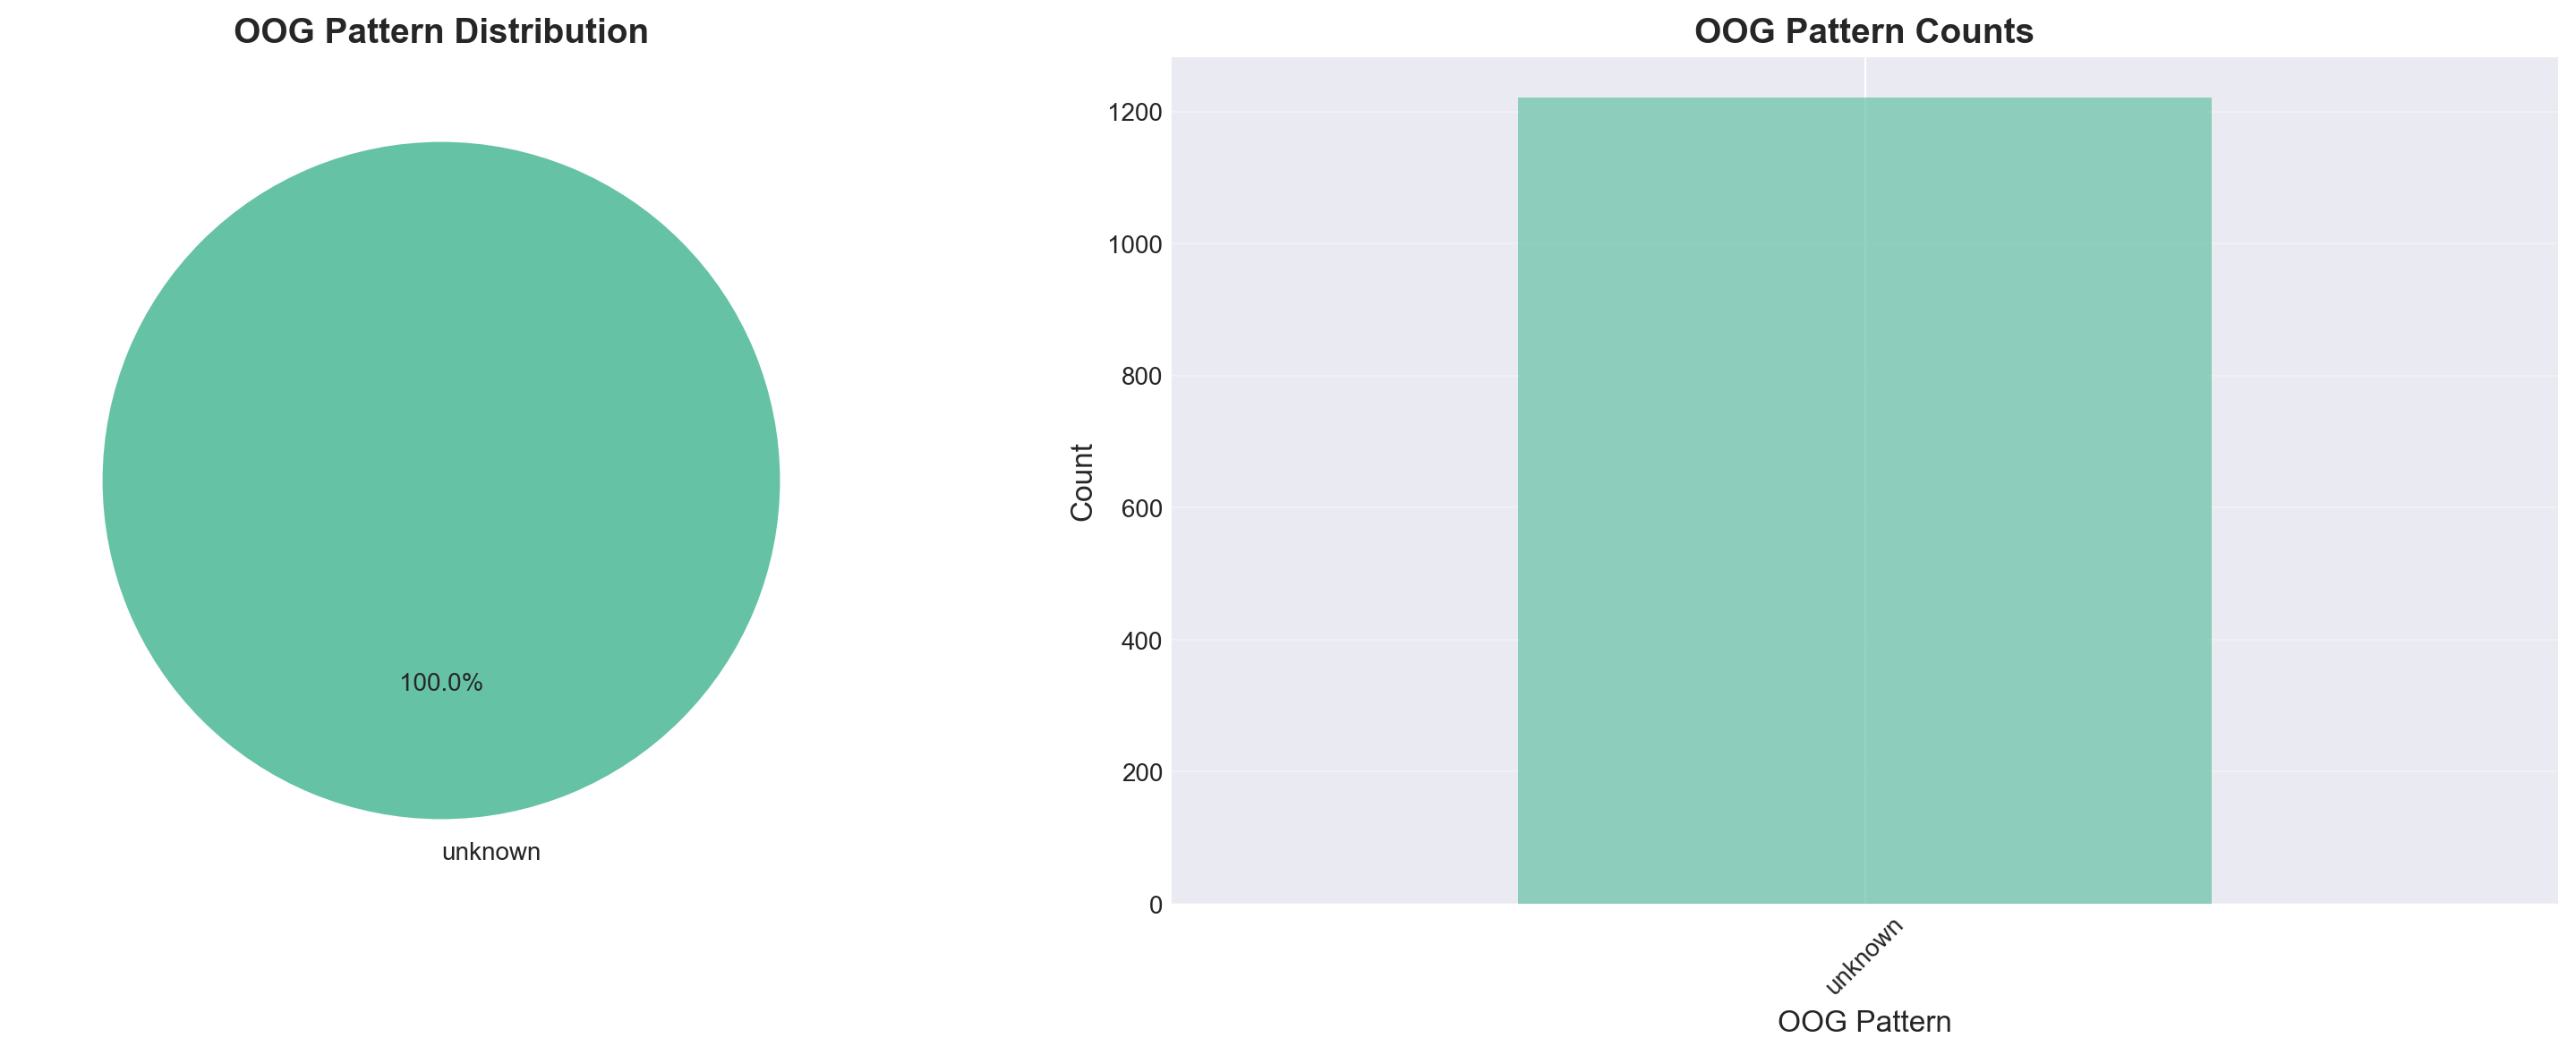

In [15]:
# Filter OOG transactions
oog_df = df[df['oog_occurred'] == 1].copy()

if len(oog_df) > 0:
    print(f"Total OOG transactions: {len(oog_df):,} ({len(oog_df)/len(df)*100:.2f}% of all divergences)")
    print("\n" + "=" * 80)
    print("OOG PATTERN DISTRIBUTION")
    print("=" * 80)
    
    # OOG pattern breakdown
    pattern_counts = oog_df['oog_pattern'].value_counts()
    print(pattern_counts)
    print()
    
    # Visualize OOG patterns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Pie chart
    colors = sns.color_palette("Set2", len(pattern_counts))
    ax1.pie(pattern_counts.values, labels=pattern_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=colors)
    ax1.set_title('OOG Pattern Distribution', fontsize=14, fontweight='bold')
    
    # Bar chart
    pattern_counts.plot(kind='bar', ax=ax2, color=colors, alpha=0.7)
    ax2.set_xlabel('OOG Pattern', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_title('OOG Pattern Counts', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
else:
    print("No OOG transactions found in the dataset.")

### 4.2 OOG Opcode Analysis

Which opcodes are most commonly associated with OOG events?

Top 20 Opcodes at OOG Point:
0x50                :    642 (52.58%)
0x60                :    364 (29.81%)
0x73                :    200 (16.38%)
0x80                :      4 ( 0.33%)
0x3a                :      3 ( 0.25%)
0x15                :      2 ( 0.16%)
0x31                :      1 ( 0.08%)
0x62                :      1 ( 0.08%)
0x61                :      1 ( 0.08%)
0x33                :      1 ( 0.08%)
0x34                :      1 ( 0.08%)
0x81                :      1 ( 0.08%)


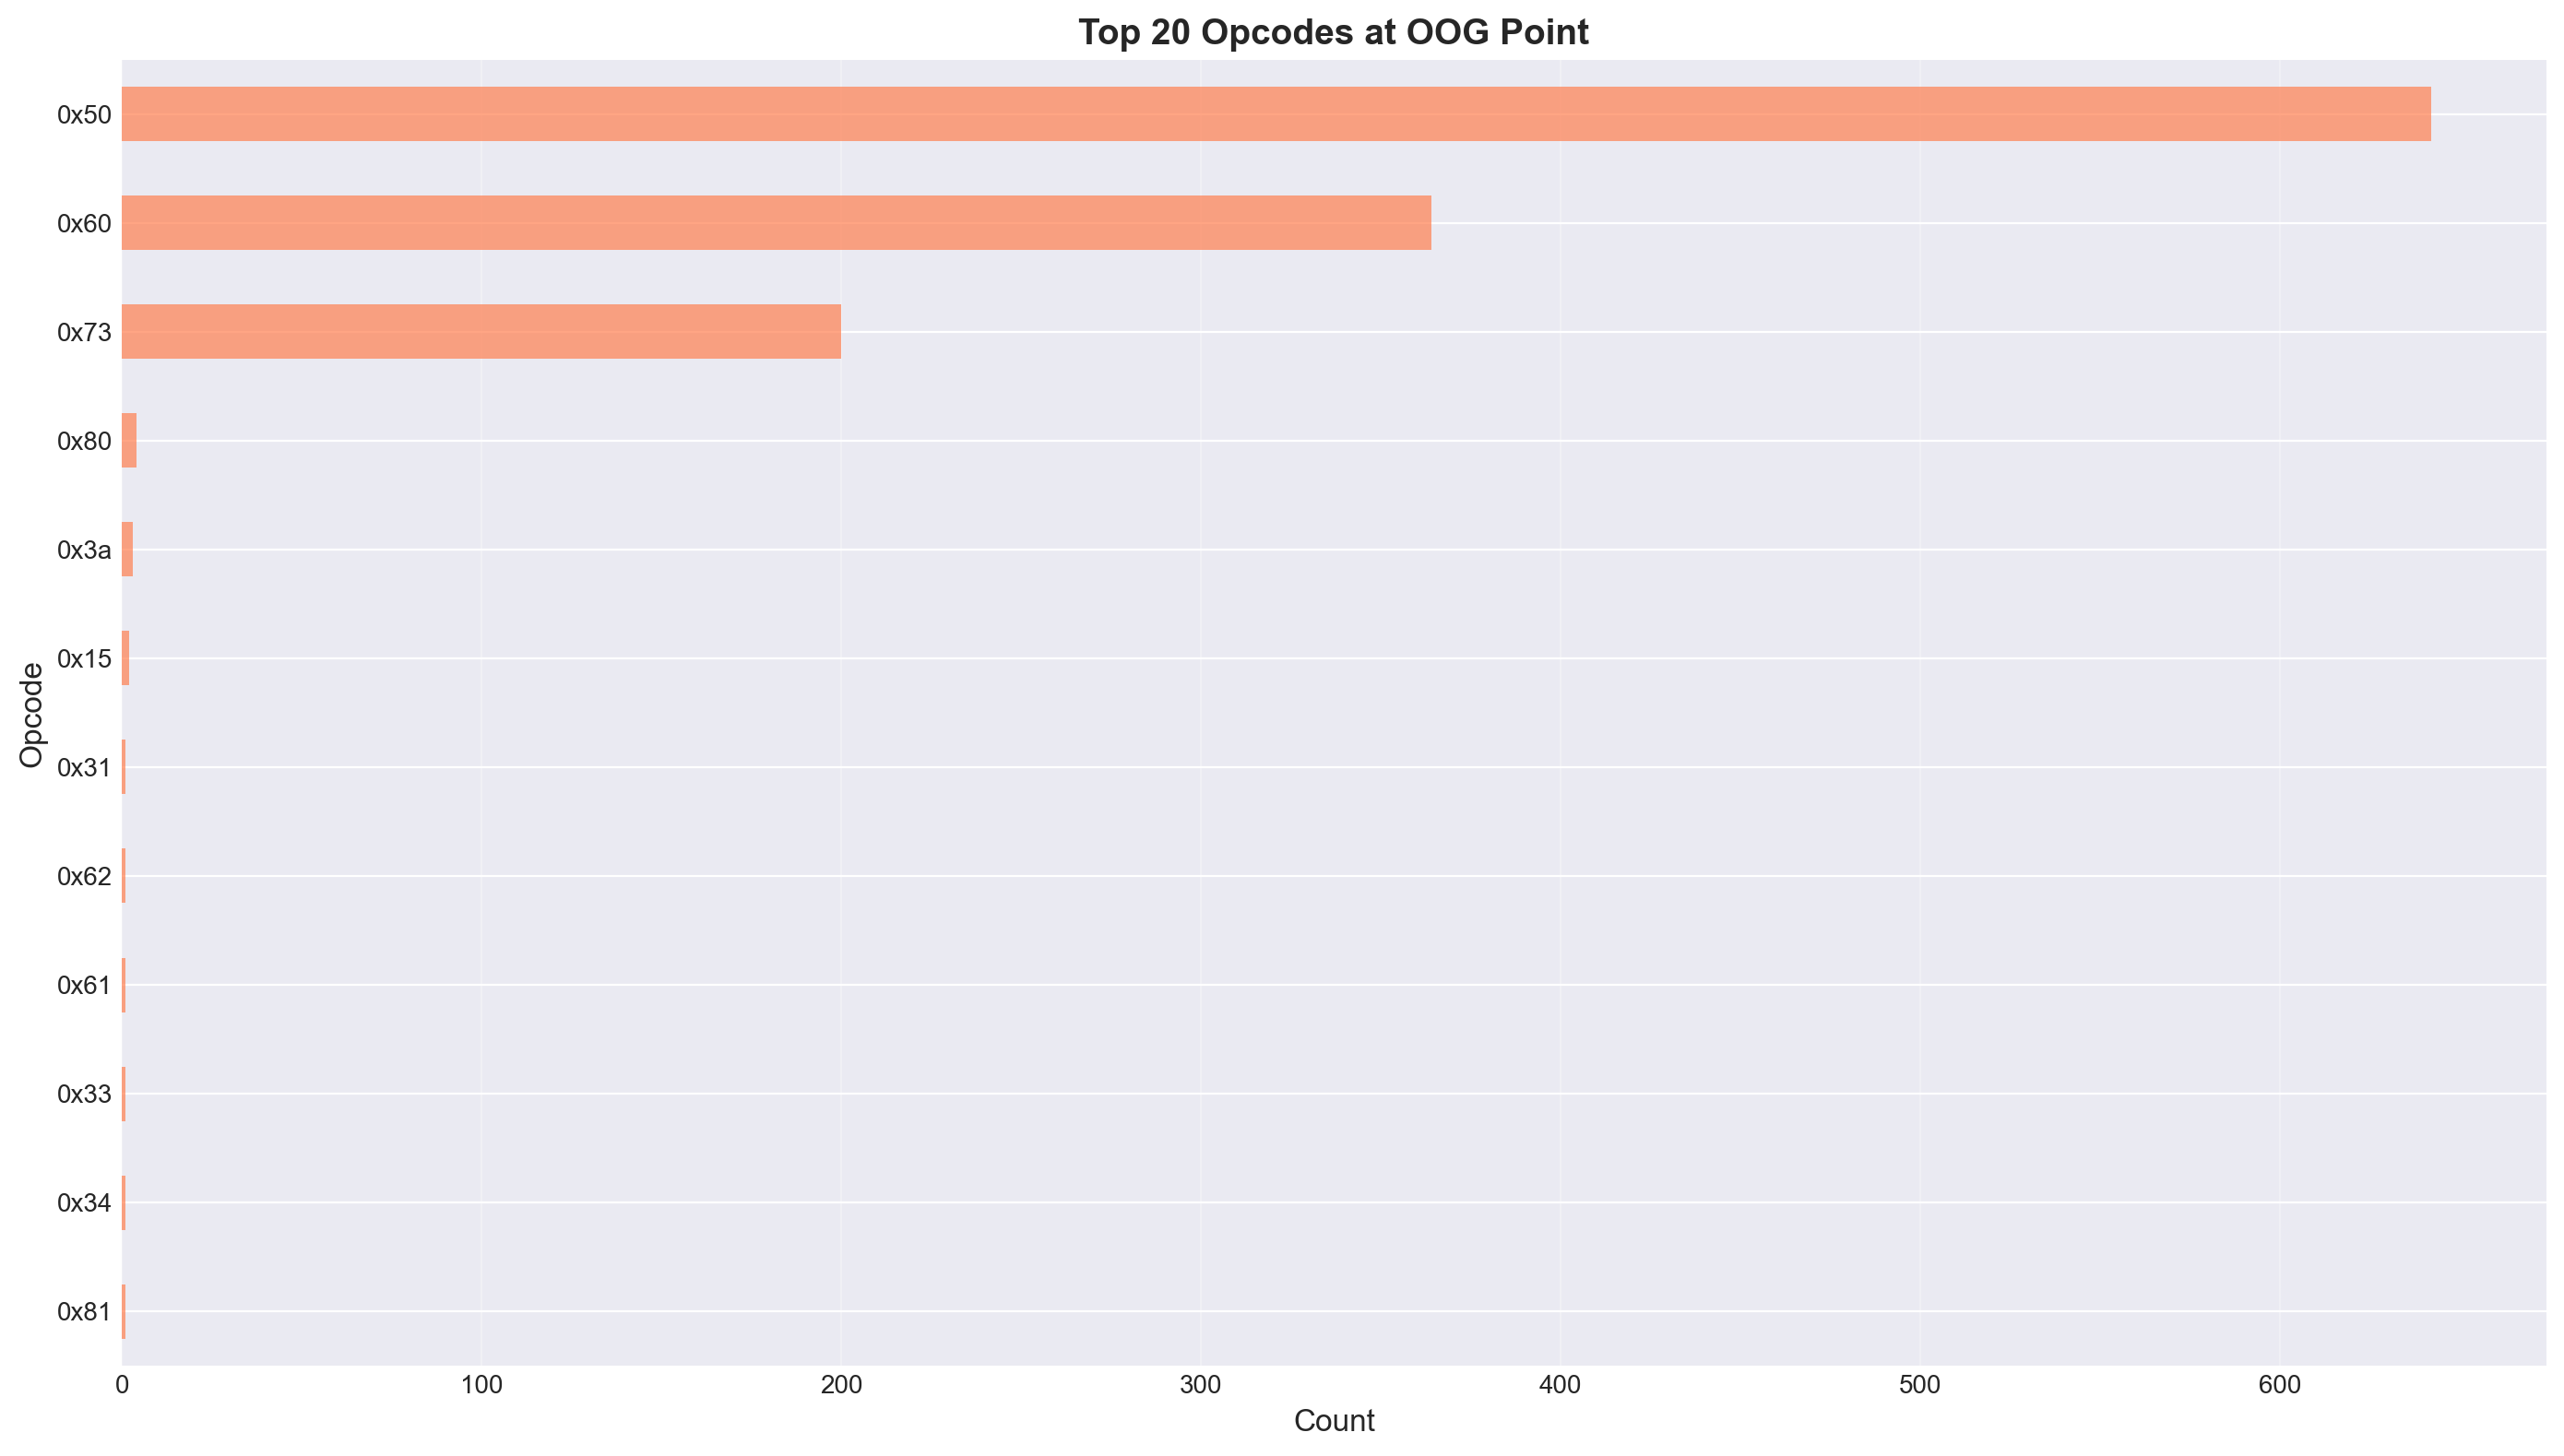

In [16]:
if len(oog_df) > 0:
    # Top opcodes causing OOG
    oog_opcodes = oog_df['oog_opcode_name'].value_counts().head(20)
    
    print("Top 20 Opcodes at OOG Point:")
    print("=" * 80)
    for opcode, count in oog_opcodes.items():
        pct = (count / len(oog_df)) * 100
        print(f"{opcode:20s}: {count:6,} ({pct:5.2f}%)")
    
    # Visualize top opcodes
    fig, ax = plt.subplots(figsize=(14, 8))
    
    oog_opcodes.plot(kind='barh', ax=ax, color='coral', alpha=0.7)
    ax.set_xlabel('Count', fontsize=12)
    ax.set_ylabel('Opcode', fontsize=12)
    ax.set_title('Top 20 Opcodes at OOG Point', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    ax.invert_yaxis()  # Highest count at top
    
    plt.tight_layout()
    plt.show()
else:
    print("No OOG data to analyze.")

### 4.3 OOG vs Non-OOG Comparison

Compare gas usage patterns between transactions that hit OOG and those that didn't.

OPERATION PATTERNS: OOG vs NON-OOG
Operation  OOG Avg  Non-OOG Avg  Ratio (OOG/Non-OOG)
    SLOAD 0.044226          0.0                    0
   SSTORE 0.057330          0.0                    0
     CALL 0.003276          0.0                    0
      LOG 0.000000          0.0                    0


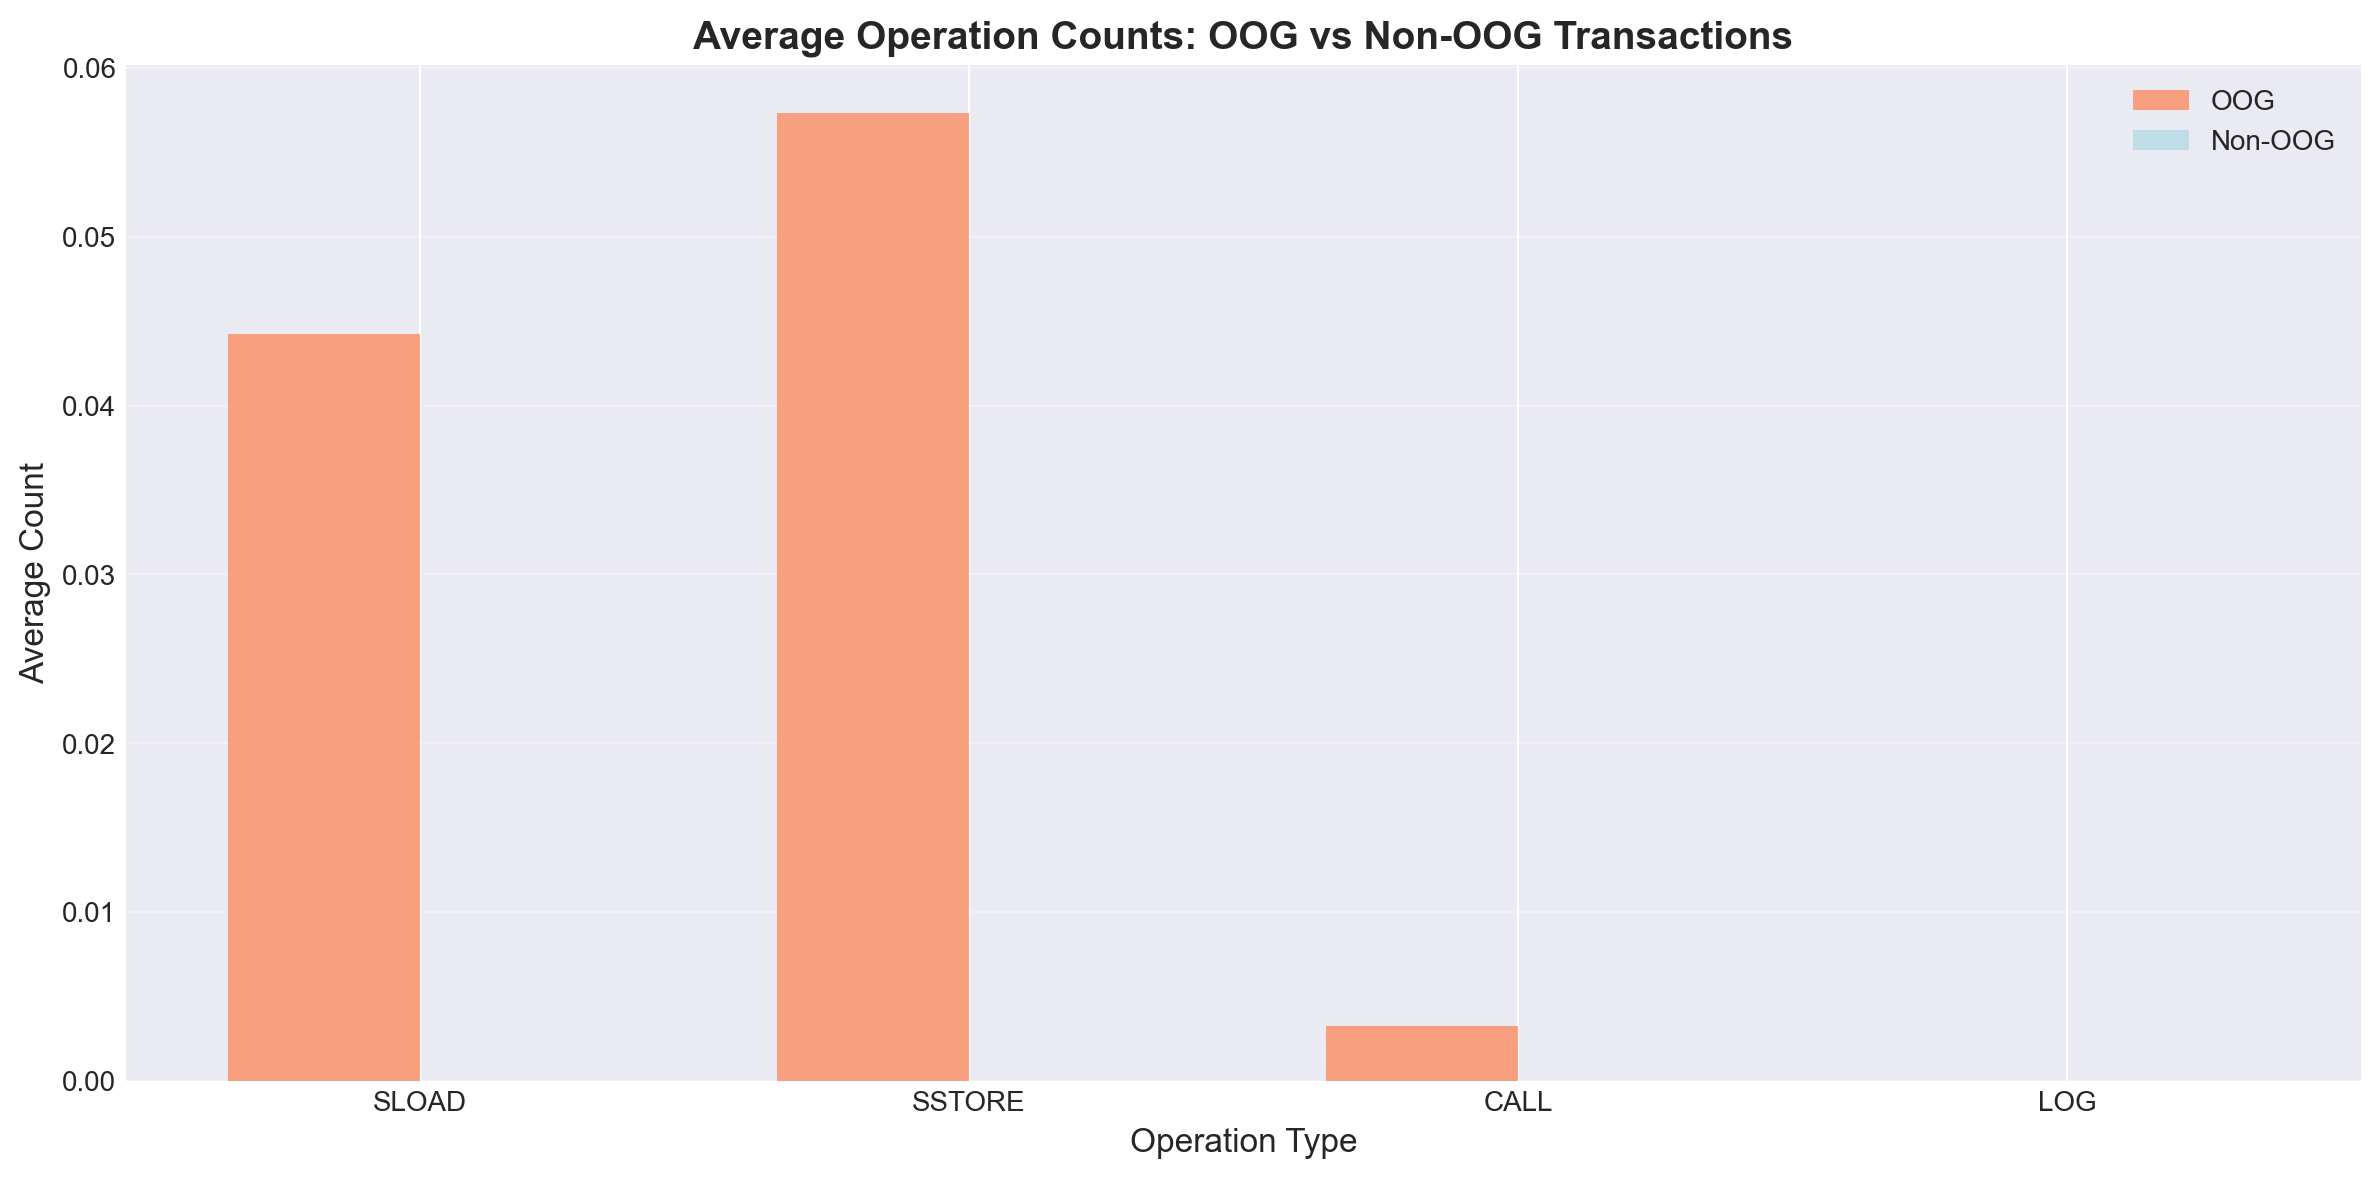


GAS USAGE COMPARISON
OOG transactions - Avg normal gas used: 286,618
Non-OOG transactions - Avg normal gas used: 26,082

OOG transactions - Median normal gas used: 300,000
Non-OOG transactions - Median normal gas used: 23,256


In [17]:
# Compare operation patterns between OOG and non-OOG transactions
non_oog_df = df[df['oog_occurred'] == 0].copy()

if len(oog_df) > 0:
    print("=" * 80)
    print("OPERATION PATTERNS: OOG vs NON-OOG")
    print("=" * 80)
    
    operations = ['sload_count', 'sstore_count', 'call_count', 'log_count']
    
    comparison_data = []
    for op in operations:
        normal_col = f'normal_{op}'
        if normal_col in df.columns:
            oog_avg = oog_df[normal_col].mean()
            non_oog_avg = non_oog_df[normal_col].mean()
            comparison_data.append({
                'Operation': op.replace('_count', '').upper(),
                'OOG Avg': oog_avg,
                'Non-OOG Avg': non_oog_avg,
                'Ratio (OOG/Non-OOG)': oog_avg / non_oog_avg if non_oog_avg > 0 else 0
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    
    # Visualize comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(operations))
    width = 0.35
    
    oog_means = [comparison_data[i]['OOG Avg'] for i in range(len(operations))]
    non_oog_means = [comparison_data[i]['Non-OOG Avg'] for i in range(len(operations))]
    
    ax.bar(x - width/2, oog_means, width, label='OOG', color='coral', alpha=0.7)
    ax.bar(x + width/2, non_oog_means, width, label='Non-OOG', color='lightblue', alpha=0.7)
    
    ax.set_xlabel('Operation Type', fontsize=12)
    ax.set_ylabel('Average Count', fontsize=12)
    ax.set_title('Average Operation Counts: OOG vs Non-OOG Transactions', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([op.replace('_count', '').upper() for op in operations])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Gas usage comparison
    print("\n" + "=" * 80)
    print("GAS USAGE COMPARISON")
    print("=" * 80)
    print(f"OOG transactions - Avg normal gas used: {oog_df['normal_gas_used'].mean():,.0f}")
    print(f"Non-OOG transactions - Avg normal gas used: {non_oog_df['normal_gas_used'].mean():,.0f}")
    print(f"\nOOG transactions - Median normal gas used: {oog_df['normal_gas_used'].median():,.0f}")
    print(f"Non-OOG transactions - Median normal gas used: {non_oog_df['normal_gas_used'].median():,.0f}")
else:
    print("No OOG data available for comparison.")